In [1]:
%matplotlib inline
import sys, os
sys.path.append(os.getcwd()+"/..")
from tools.system.imgtovideo import imgs_to_video
from data import load_data
import matplotlib.pyplot as plt
import numpy as np
import theano
import theano.tensor as T
from lasagne import layers as L
from lasagnekit.misc.plot_weights import dispims_color, tile_raster_images
import pandas as pd

from tqdm import tqdm
import base64
import json

from skimage.io import imread, imsave
from skimage.transform import resize

from IPython.display import HTML, Image


from tools.brushstroke.common import (
    resize_set, load_model, get_bias, 
    get_scale, build_brush_func,
    build_encode_func,
    build_image_to_code_func,
    build_code_to_image,
    to_grid_of_images,
    seq_to_video,
    embed_video,
    disp_grid,
    prop_uniques,
    hash_array,
    normalize,
    sigmoid,
    build_pointer_images)

/home/mcherti/work/code/external/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Couldn't import dot_parser, loading of dot files will not be possible.


## Load model and build functions

In [85]:
model, data, layers = load_model("../jobs/results/cab58e9c2be45aa38ae02b3823e6d180/model.pkl")
w, h = layers['output'].output_shape[2:]
print(json.dumps(model.hypers['model_params'], indent=2))

Loading data...


INFO:tasks:Loading data...


(128, 3072)
Loading the model...


INFO:tasks:Loading the model...


Compiling the model...


INFO:tasks:Compiling the model...


{
  "nb_recurrent_layers": 3, 
  "color": "predicted", 
  "n_steps": 83, 
  "normalize_func": "sigmoid", 
  "nb_recurrent_units": [
    500, 
    400, 
    500
  ], 
  "y_stride": 1, 
  "reduce_func": "sum", 
  "nonlin_out": "msigmoid", 
  "parallel_reduce_func": "sum", 
  "patch_size": 3, 
  "y_sigma": 0.5, 
  "nonlin": "very_leaky_rectify", 
  "y_min": 0, 
  "nb_fc_units": [
    800
  ], 
  "x_max": "width", 
  "patch_index": 0, 
  "parallel": 3, 
  "x_stride": 1, 
  "nb_fc_layers": 1, 
  "parallel_share": false, 
  "y_max": "height", 
  "eps": 0, 
  "recurrent_model": "lstm", 
  "x_min": 0, 
  "x_sigma": 0.5
}


In [86]:
for lay in layers:
    print(lay)

input
fc1_net0
recurrent2_0
coord_0
brush_0
fc1_net1
recurrent2_1
coord_1
brush_1
fc1_net2
recurrent2_2
coord_2
brush_2
raw_output
scaled_output
biased_output
output


In [87]:
nb_parallel = model.hypers['model_params'].get('parallel', 1)

In [88]:
encoders = []
for i in range(nb_parallel):
    encoder = build_encode_func(layers, lay='coord_{}'.format(i))
    encoders.append(encoder)

In [89]:
lays = ['brush_{}'.format(i) for i in range(nb_parallel)]
lays = tuple(lays)
brush = build_brush_func(
    layers, 
    lay=lays,
    nonlin=lambda x:x) # transforms an image to sequence of images

In [90]:
reconstruct = model.reconstruct # reconstructs an image

In [91]:
scale = get_scale(layers)
bias = get_bias(layers)

## Get coords from images

## Create a video

In [92]:
X = model.preprocess(data.X[0:10*10])

In [96]:
codes = []
for encoder in encoders:
    code = encoder(X)
    codes.append(code)

cols = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 1, 0)]
pointers = []
for i, code in enumerate(codes):
    pointer = build_pointer_images(code, cols[i], w, h, p=1)
    pointers.append(pointer)
pointers = sum(pointers)
seq_to_video(pointers, 'pointers.mp4')
embed_video('pointers.mp4')

/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/img_to_videoZWppUe/img00000000.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/img_to_videoZWppUe/img00000006.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/img_to_videoZWppUe/img00000007.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/img_to_videoZWppUe/img00000008.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/img_to_videoZWppUe/img00

ffmpeg -framerate 8 -i img%08d.png -c:v libx264 -r 8 -pix_fmt yuv420p /home/mcherti/work/code/feature_generation/ipynb/pointers.mp4


In [97]:
imgs = brush(X) # (examples, time, w, h)
imgs = sum(imgs)
imgs = sigmoid(imgs * scale + bias) 
imgs = imgs + pointers * (1-imgs)
imgs = 1 - imgs
seq_to_video(imgs, 'seq.mp4')
embed_video('seq.mp4')

/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/img_to_videoWB0iVg/img00000000.png is a low contrast image
  warn('%s is a low contrast image' % fname)


ffmpeg -framerate 8 -i img%08d.png -c:v libx264 -r 8 -pix_fmt yuv420p /home/mcherti/work/code/feature_generation/ipynb/seq.mp4


## Reconstruct

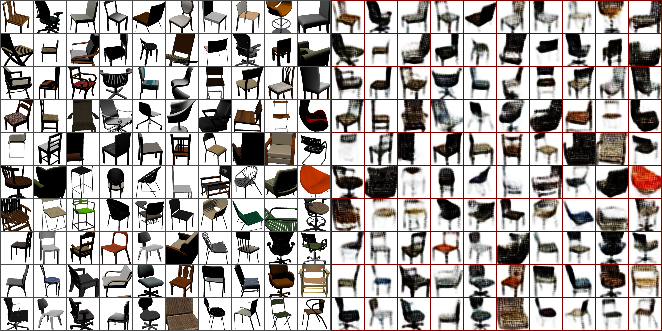

In [98]:
im1 = disp_grid(model.preprocess(data.X[0:100]), border=1, bordercolor=(.3, .3, .3))
im2 = disp_grid(reconstruct(model.preprocess(data.X[0:100])), border=1, bordercolor=(.5, 0, 0))
im_mix = np.empty(( max(im1.shape[0], im2.shape[0]), im1.shape[1] + im2.shape[1], 3))
im_mix[0:im1.shape[0], 0:im1.shape[1]] = im1
im_mix[0:im2.shape[0], im1.shape[1]:] = im2
imsave('im_mix.png', im_mix)
Image('im_mix.png')

## iterative refinement

In [16]:
np.random.seed(2)

nb_iter = 50
nb_examples = 9
thresh = None
use_noise = True
c = layers['output'].output_shape[1]
# PREP
if thresh == 'moving':
    whitepx_ratio = (data.X>0.5).sum() / np.ones_like(data.X).sum()

imgs = np.empty((nb_examples, nb_iter + 1, c, w, h)) # 1 = color channel
imgs = imgs.astype(np.float32)
imgs[:, 0] = np.random.uniform(size=(nb_examples, c, w, h))

if use_noise: noise = np.random.normal(0, 0.5, size=imgs[:, 0].shape).astype(np.float32) #(for colored images)
else: noise = 0


scores = []
diversities = []

# ITERATIOn

for i in tqdm(range(1, nb_iter + 1)):
    
    #if use_noise:noise = np.random.normal(0, 0.1, size=imgs[:, 0].shape).astype(np.float32) #(for colored images)
    #else:noise = 0
    imgs[:, i] = model.reconstruct(imgs[:, i - 1] + noise)
    if c == 1:
        if thresh == 'moving':
            vals = imgs[:, i].flatten()
            vals = vals[np.argsort(vals)]
            thresh_ = vals[-int(whitepx_ratio * len(vals)) - 1]
        else:
            thresh_ = thresh
        if thresh_:
            imgs[:, i] = imgs[:, i] > thresh_ # binarize
    score = np.abs(imgs[:, i - 1] - imgs[:, i]).sum()
    scores.append(score)
    diversity = prop_uniques(imgs[:, i])
    diversities.append(diversity)

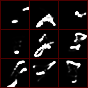

In [17]:
fig = plt.figure(figsize=(10, 10))
img = disp_grid(imgs[:, -1], border=1, bordercolor=(0.3, 0, 0))
imsave('ir.png', img)
Image('ir.png', width=500, height=500)

In [ ]:
seq_to_video(imgs, 'ir.mp4', border=0, bordercolor=(0, 0, 0))
embed_video('ir.mp4')

In [ ]:
plt.title('Score')
plt.plot(np.log(np.array(scores)) / np.log(10))
plt.show()
plt.title('Diversity')
plt.plot(diversities)
plt.show()

## Feeding a new image

In [ ]:
#dt_test = load_data('strokes', w=w,h=h) # for grayscale
#dt_test = load_data('digits', w=w, h=h)
dt_test = load_data('omniglot', w=w, h=h)

In [ ]:

# load from file

nb = 100
dt = dt_test.X[0:nb]
try:
    dt = dt.reshape((nb, c, w, h))
except Exception:
    dt = dt.reshape((nb, 1, w, h))
    dt = dt * np.ones((1, 3, 1, 1))
    dt = dt.astype(np.float32)
print(dt.shape)
rec = reconstruct(dt)
print(((rec - dt)**2).mean())

im1 = disp_grid(model.preprocess(dt[0:nb]), border=1, bordercolor=(.3, .3, .3))
im2 = disp_grid(reconstruct(model.preprocess(rec[0:nb])), border=1, bordercolor=(.5, 0, 0))
im_mix = np.empty((im1.shape[0], im1.shape[1] + im2.shape[1], 3))
im_mix[:, 0:im1.shape[1]] = im1
im_mix[:, im1.shape[1]:] = im2
imsave('im_mix_new_dataset.png', im_mix)
Image('im_mix_new_dataset.png')

## interpolation

In [120]:
lay = ['fc1_net{}'.format(i) for i in range(nb_parallel)]
lay = tuple(lay)

#tensors = tuple(T.tensor3() for _ in range(nb_parallel))
tensors = tuple(T.matrix() for _ in range(nb_parallel))

img2code = build_image_to_code_func(layers, lay=lay)
code2img = build_code_to_image(layers, lay=lay, X=tensors)

In [123]:
indices = np.random.randint(0, len(data.X), size=4)
codes = img2code(model.preprocess(data.X[indices]))
shapes = [c.shape[1:] for c in codes]
codes_flat = [c.reshape(c.shape[0], -1) for c in codes]
sizes = [c.shape[1] for c in codes_flat]
codes_concat = np.concatenate(codes_flat, axis=1)

z_dim = codes_concat.shape[1:]
D = 20
alpha = np.linspace(0, 1, D)
beta = np.linspace(0, 1, D)
grid_codes = np.empty((D*D,) + z_dim, dtype='float32')
k = 0
for a in alpha:
    for b in beta:
        grid_codes[k] = a*b*codes_concat[0] + a*(1-b)*codes_concat[1] + (1-a)*b*codes_concat[2]  + (1-a)*(1-b)*codes_concat[3]
        k +=1

i = 0
orig_codes = []
for s in sizes:
    orig_codes.append(grid_codes[:, i:i+s])
    i+=s
orig_codes = [orig_code.reshape((orig_code.shape[0],) + shape) for orig_code, shape in zip(orig_codes, shapes)]
print(orig_codes[0].shape)
grid_imgs = code2img(*orig_codes)

(400, 800)


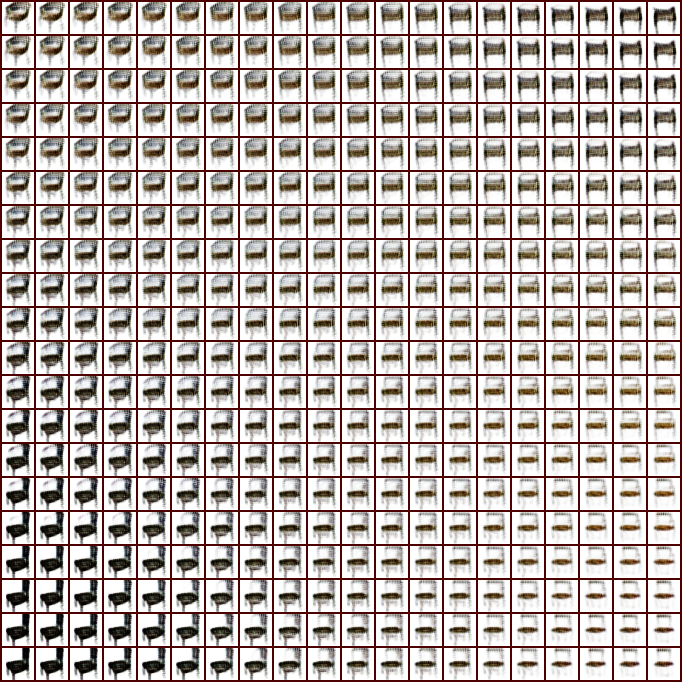

In [124]:
imsave('grid.png', disp_grid(grid_imgs, border=2, bordercolor=(0.3,0.,0.)))
Image('grid.png', width=500, height=500)